In [15]:
from user_constants import *
import tpu_simulation_utilities as tsu
import tensorflow.compat.v1 as tf
import numpy as np
import os
import io
import sys
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
from skimage import transform
import ipywidgets as widgets
from osgeo import gdal
from typing import Any, Callable, Iterable, Sequence, List, Dict, Mapping, MutableMapping, MutableSequence, Optional, Text, Tuple, Union

if PUBLIC_COLAB:
  # Authenticate to access Google Cloud Storage.
  from google.colab import auth  # pylint: disable=g-import-not-at-top
  auth.authenticate_user()

def dam_break_left_1d(y, x, Ly, nx, ny, dem):
    y = y -  1.0 * Ly / 3.0
    z = (1-tf.math.sign(y))*2.5+tsu.SAINT_VENANT_EPS+5
    z = tf.expand_dims(z,axis=0)
    z = tf.repeat(z, nx,axis = 0)
    return z


class TPUSimulationManager:
  """A class that manages a simulation.

  This concrete class is largely responsible for creating and running the
  simulation. It requires a `GridParametrization`, which it uses to define
  the computation grid. It also requires a `TPUSimulationBuilder` in order to
  create the `TPUSimulation`. Next, it requires a `RunnerBuilder` to create the
  runner that will actually perform the simulation.

  Given these ingredients, the manager creates a `tf.Session`, and uses it
  to initialize the `TPUSimulation`. It uses the `TPUSimulation` to initialize
  the `TPUSimulationRunner` object. Having assembled the runner, the simulation
  is started with a call to `run_simulation`. Finally, the TPU session is shut
  down.
  """

  def __init__(
      self,
      params: tsu.GridParametrization,
      simulation_builder,
      session_runner_builder) -> None:
    """Initializes a `TPUSimulationManager`.

    Args:
      params: An instance of `GridParametrization`.
      simulation_builder: An instance of `TPUSimulationBuilder`.
      session_runner_builder: An instance of `SessionRunnerBuilder`.
    """
    self._params = params
    config = tf.ConfigProto(isolate_session_state=True)
    self._sess = tf.Session(config=config, target=TPU_WORKER)
    self._sim = simulation_builder(self._sess)
    self._session_runner = session_runner_builder(self._sim)
    self._sess.run(tf.global_variables_initializer())

  def run_simulation(self, start_time_secs: float = 0) -> None:
    """Runs the simulation."""
    start_step = int(round(start_time_secs / self._params.dt))
    self._session_runner(self._sess, start_step)

  def __del__(self):
    tf.tpu.shutdown_system()


def get_sim_builder(
    params: tsu.SaintVenantParams,
    unpadded_dem: np.ndarray,
    unpadded_manning_matrix: np.ndarray,
    h_bcs: Sequence[tsu.BoundaryCondition],
    q_x_bcs: Sequence[tsu.BoundaryCondition],
    q_y_bcs: Sequence[tsu.BoundaryCondition],
    init_files_manager: tsu.InitFilesManager,
    input_file_format: Optional[Text] = None,
    start_time_secs: float = 0,
    water_initial_condition_function = tsu.constant_height_zeros,
    flux_initial_condition_function = tsu.constant_height_zeros) -> Callable[[tf.Session], tsu.TPUSimulation]:
  """Returns a function that builds a TPUSimulation given a `tf.Session`."""
  init_fn_builder = (
      tsu.SaintVenantRealisticInitFnBuilder(
          params, tsu.INIT_STATE_KEYS, unpadded_dem, unpadded_manning_matrix,
          init_files_manager, input_file_format,
          start_time_secs, water_initial_condition_function, flux_initial_condition_function))
  step_fn = tsu.SaintVenantRiverChannelStep(
      tsu.ApplyKernelOp(), params, h_bcs, q_x_bcs, q_y_bcs)

  step_fn = tsu.DynamicStepUpdater(
      step_fn, num_secs_per_while_loop=params.num_secs_per_cycle, dt=params.dt)

  step_fn = tsu.build_step_fn(params, step_fn, tsu.STATE_KEYS,
                          tsu.ADDITIONAL_STATE_KEYS)

  def sim_builder(sess):
    topology = tf.tpu.experimental.Topology(
        sess.run(tf.tpu.initialize_system()))

    return tsu.TPUSimulation(
        init_fn=init_fn_builder.init_fn,
        step_fn=step_fn,
        computation_shape=params.computation_shape,
        tpu_topology=topology,
        host_vars_filter=tsu.INIT_STATE_KEYS)

  return sim_builder


def run_simulation(
    dem_tiff_filename: Text, resolution: int, num_secs: float,
    num_secs_per_cycle: float, dt: float, cx: int, cy: int,
    run_dir: Text, start_time_secs: float = 0) -> None:
  """Runs the simulation."""
  # Necessary Component of Running Simulation, no editing here.
  slope = 1e-4
  input_file_format = ('{}' + f'-{start_time_secs}.np' if start_time_secs > 0
                       else None)

  unpadded_dem,geoinfo = tsu.load_dem_from_tiff_file(dem_tiff_filename,resolution)
  unpadded_river_mask = np.ones_like(unpadded_dem, dtype=bool)
  unpadded_manning_matrix = tsu.get_manning_matrix_from_river_mask(
      unpadded_river_mask, tsu.MANNING_COEFF_RIVER, tsu.MANNING_COEFF_FLOODPLAIN)
  params = tsu.get_sv_params(unpadded_dem.shape, resolution, num_secs,
                         num_secs_per_cycle, cx, cy, dt)
  print('params:', params)
  
  # SETS THE BOUNDARY CONDITIONS FOR HEIGHT, FLUX IN Y, FLUX IN X
  h_bcs = [
      tsu.NeumannBoundary(
          boundary_side=tsu.BoundarySide.LEFT,
          fraction_start=0,
          fraction_end=1.0,
          left_padding=params.left_padding,
          top_padding=params.top_padding,
          slope=slope,
          value=0.0*3940,
          unpadded_dem=unpadded_dem,
          unpadded_manning_matrix=unpadded_manning_matrix),
      tsu.NeumannBoundary(
          boundary_side=tsu.BoundarySide.RIGHT,
          fraction_start=0,
          fraction_end=1.0,
          left_padding=params.left_padding,
          top_padding=params.top_padding,
          slope=slope,
          value=0.0,
          unpadded_dem=unpadded_dem,
          unpadded_manning_matrix=unpadded_manning_matrix)
  ]

  q_y_bcs = [
      tsu.NeumannBoundary(
          boundary_side=tsu.BoundarySide.LEFT,
          fraction_start=0,
          fraction_end=1.0,
          left_padding=params.left_padding,
          top_padding=params.top_padding,
          slope=slope,
          value=0.0,
          unpadded_dem=unpadded_dem,
          unpadded_manning_matrix=unpadded_manning_matrix),
      tsu.DirichletBoundary(
          boundary_side=tsu.BoundarySide.RIGHT,
          fraction_start=0,
          fraction_end=1.0,
          left_padding=params.left_padding,
          top_padding=params.top_padding,
          slope=slope,
          value=0.0,
          unpadded_dem=unpadded_dem,
          unpadded_manning_matrix=unpadded_manning_matrix)
  ]

  q_x_bcs = [
     tsu.NeumannBoundary(
          boundary_side=tsu.BoundarySide.TOP,
          fraction_start=0,
          fraction_end=1.0,
          left_padding=params.left_padding,
          top_padding=params.top_padding,
          slope=slope,
          value=0.0,
          unpadded_dem=unpadded_dem,
          unpadded_manning_matrix=unpadded_manning_matrix),
      tsu.NeumannBoundary(
          boundary_side=tsu.BoundarySide.BOTTOM,
          fraction_start=0,
          fraction_end=1.0,
          left_padding=params.left_padding,
          top_padding=params.top_padding,
          slope=slope,
          value=0.0,
          unpadded_dem=unpadded_dem,
          unpadded_manning_matrix=unpadded_manning_matrix)]

  # NO NEED TO EDIT THE FOLLOWING
  init_files_manager = tsu.InitFilesManager(
      params, tsu.three_d_subgrid_of_2d_grid, run_dir)

  # LAST TWO ARGUMENTS SET INITIAL CONDITIONS IN HEIGHT AND FLUX IN Y DIRECTION
  sim_builder = get_sim_builder(
      params, unpadded_dem, unpadded_manning_matrix,h_bcs,q_x_bcs,q_y_bcs,
      init_files_manager, input_file_format, start_time_secs, 
      dam_break_left_1d, tsu.constant_height_zeros)

  def session_runner_builder(sim):
    return tsu.get_session_runner_builder(params, init_files_manager, run_dir, sim)

  manager = TPUSimulationManager(params, sim_builder, session_runner_builder)
  manager.run_simulation(start_time_secs)

In [45]:
# SIMULATION PARAMETERS - NEED TO BE SET
resolution, dt, cx = 1, 5e-3, 1
start_time_secs, num_secs, num_secs_per_cycle = 0, 10.0, 1.0
# SIMULATION DEM FILE NAME
dem_bucket_filename = f'/content/flat.tif'

# NO NEED TO EDIT THIS COMPONENT
dem_tiff_filename = tsu.get_dem_tiff_filename(dem_bucket_filename,resolution)
run_dir = f'gs://{BUCKET}'
if PUBLIC_COLAB:
  cy = 8
  os.environ['GOOGLE_CLOUD_PROJECT'] = PROJECT_ID
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']

In [ ]:
# RUN SIMULATION ON TPU
if PUBLIC_COLAB:
  g = tf.Graph()
  run_meta = tf.RunMetadata()
  with g.as_default():
    run_simulation(dem_tiff_filename, resolution, num_secs,
                  num_secs_per_cycle, dt, cx, cy, run_dir,
                  start_time_secs)

In [ ]:
# Load the DEM and the heightmaps.
dem, geoinfo = tsu.load_dem_from_tiff_file(dem_tiff_filename,resolution)
dem_shape = dem.shape
heightmaps = {}
t_range = np.arange(start_time_secs,num_secs + num_secs_per_cycle,num_secs_per_cycle)
for t in t_range:
  t  = round(t,3)
  filename = os.path.join(run_dir, f'h-{t}.np')
  print(f'Loading heightmap: h-{t}.np')
  with tf.io.gfile.GFile(filename, 'rb') as f:
    heightmaps[t] = np.load(f)
  
resize_factor = 1
resize_shape = [dem_shape[0] // resize_factor, dem_shape[1] // resize_factor]
scaled_dem = transform.resize(dem, resize_shape)
scaled_heightmaps = {}

for ts, hmap in heightmaps.items():
  scaled_heightmaps[ts] = transform.resize(hmap, resize_shape)

In [48]:
def wet_dam_break_verification(t,x):
  shock_x = (1/ 3) * 2000
  h_l = 10
  def func(c_m):
    return -8 * 5 * _G * c_m * c_m * np.square(np.sqrt(_G*h_l) - c_m) + np.square(c_m * c_m - 5 * _G)*(c_m * c_m + _G * 5) 
  c_m = fsolve(func,h_l)
  x_a = shock_x - t * np.sqrt(_G * h_l)
  x_b = shock_x + t * (2 * np.sqrt(_G * h_l) - 3 * c_m)
  x_c = shock_x + t * (2 * c_m * c_m * (np.sqrt(_G * h_l) - c_m)) / (c_m *c_m - _G * 5)
  h_analytic = np.piecewise(x,[x <= x_a, np.logical_and(x > x_a, x <= x_b), np.logical_and(x > x_b, x <= x_c), x> x_c],
                  [lambda x: h_l, lambda x:  (4 / (9 * _G)) * np.square(np.sqrt(_G * h_l) - (x - shock_x) / (2*t)),
                    lambda x: c_m * c_m / _G, lambda x: 5]) + tsu.SAINT_VENANT_EPS
  return h_analytic

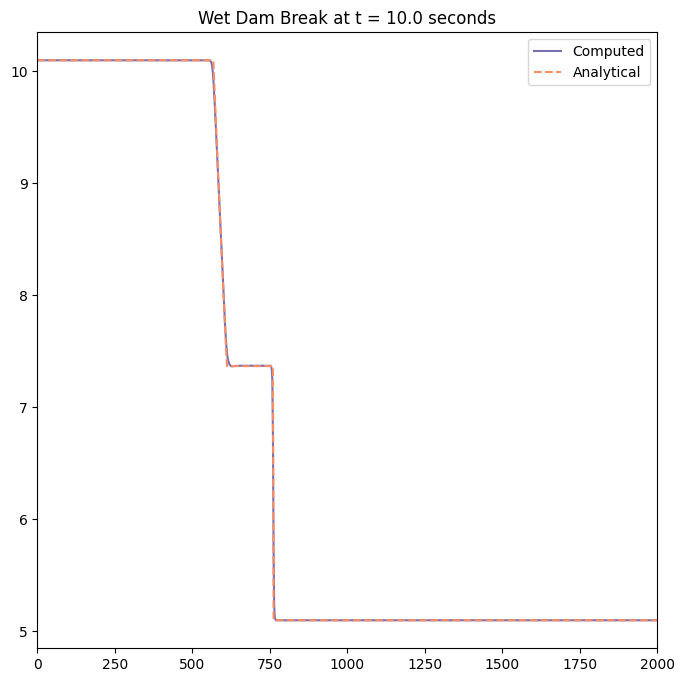

In [32]:
%matplotlib inline
from scipy.optimize import fsolve
_G = 9.8
def plot_shock(time_secs,ax=None):
  if (ax == None):
    plt.figure(figsize=(8, 8), dpi=100)
    ax = plt.gca()
  t = time_secs
  row = 80
  ax.plot(np.linspace(0,2000,2001), scaled_heightmaps[t][row,:],color = '#7570b3',label='Computed')
  x = np.linspace(0,2000,2001)
  h_analytic = wet_dam_break_verification(t,x)
  ax.plot(x, h_analytic, label='Analytical',color='#fc8d62',linestyle='dashed')
  ax.legend(loc='upper right')
  ax.set_title('Wet Dam Break at t = ' + str(t) + ' seconds')
  ax.set_xlim([500,1000])

def plot_error(ax):
  linf ={}
  l2norm = {}
  row = 100
  shock_x = (1/ 3) * 2000
  h_l = 10
  def func(c_m):
    return -8 * 5 * _G * c_m * c_m * np.square(np.sqrt(_G*h_l) - c_m) + np.square(c_m * c_m - 5 * _G)*(c_m * c_m + _G * 5)
  c_m = fsolve(func,h_l)
  x = np.linspace(0,2000,2001)
  for ts, hmap in scaled_heightmaps.items():
    if ts == 0:
      continue
    x_c = shock_x + ts * (2 * c_m * c_m * (np.sqrt(_G * h_l) - c_m)) / (c_m *c_m - _G * 5)
    skip = np.searchsorted(x,x_c)
    skip = skip[0]
    linf[ts] = (np.max(abs(hmap[row,1:skip-2]-wet_dam_break_verification(ts,x)[1:skip-2])))/ (np.max(abs(wet_dam_break_verification(ts,x))))
    l2norm[ts] = np.sqrt(np.sum(np.square(hmap[row,1:skip-2]-wet_dam_break_verification(ts,x)[1:skip-2]))) / np.sqrt(np.sum(np.square(wet_dam_break_verification(ts,x)[1:skip-2])))
  fig = plt.figure(figsize=(6,4))
  ax.plot(np.array([*linf]), [*linf.values()], label= '$L_\infty$',color='#1f78b4')
  ax.plot(np.array([*l2norm]), [*l2norm.values()],label='$L_2$',color='#33a02c')
  ax.set_yscale('log')
  ax.set_xlabel('Time [s]')
  ax.set_title('Relative Error in Norm\n of Wet Dam Break Solution')
  ax.legend(fontsize='x-large')

if PUBLIC_COLAB:
  slider = widgets.FloatSlider(
      value=num_secs,
      min=start_time_secs, max=num_secs,
      step=num_secs_per_cycle, readout_format='.4f')
  out = widgets.interactive_output(
      lambda time_secs: plot_shock(time_secs), {'time_secs': slider})
  display(widgets.VBox([slider, out]))

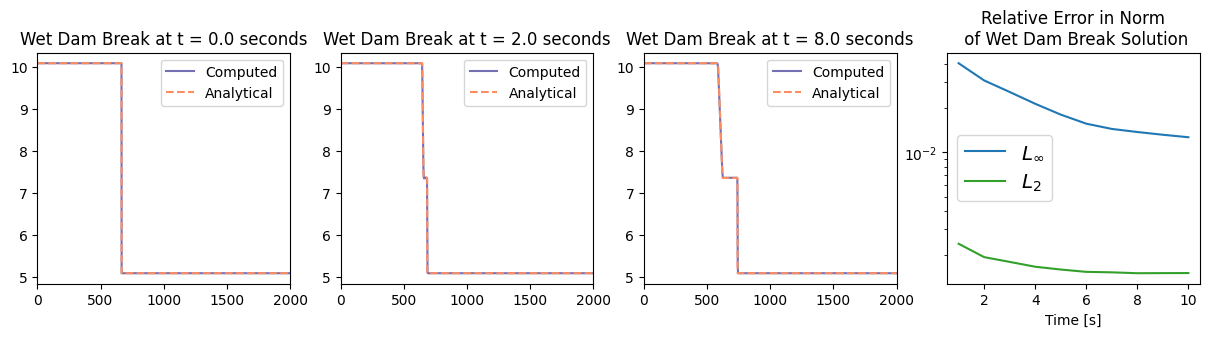

<Figure size 600x400 with 0 Axes>

In [21]:
fig, ax = plt.subplots(1,4,figsize=(15,3),dpi=100)
plot_shock(0.0,ax[0])
plot_shock(2.0,ax[1])
plot_shock(8.0,ax[2])
plot_error(ax[3])